# Presidential Polls Analysis #

- Bobby Nguyen, Jason Green

In [325]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import model_selection
from sklearn.metrics import r2_score
from pylab import *
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.utils import shuffle
import random
import warnings
warnings.filterwarnings('ignore')

In [326]:
#!{sys.executable} -m pip install pyod

# I. Data Prep #

### 1. Loading Data ###

In [327]:
dataset = pd.read_csv('presidential_polls.csv')
dataset.columns
dataset.head(5)

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/25/2016,10/31/2016,Google Consumer Surveys,B,...,42.64140,40.86509,5.675099,NaN,NaN,https://datastudio.google.com/u/0/#/org//repor...,47940,74999,11/1/16,15:09:38 1 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,43.29659,44.72984,3.401513,NaN,NaN,http://www.langerresearch.com/wp-content/uploa...,47881,74936,11/1/16,15:09:38 1 Nov 2016
2,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Virginia,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,46.29779,40.72604,6.401513,NaN,NaN,https://www.washingtonpost.com/local/virginia-...,47880,74934,11/1/16,15:09:38 1 Nov 2016
3,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Florida,10/20/2016,10/24/2016,SurveyUSA,A,...,46.35931,45.30585,1.777730,NaN,NaN,http://www.baynews9.com/content/news/baynews9/...,47465,74252,10/25/16,15:09:38 1 Nov 2016
4,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/20/2016,10/25/2016,Pew Research Center,B+,...,45.32744,42.20888,3.618320,NaN,NaN,http://www.people-press.org/2016/10/27/as-elec...,47616,74519,10/27/16,15:09:38 1 Nov 2016


### 2. Dropping unnecessary columns ###

In [328]:
df = dataset.drop(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'startdate', 'enddate', 'pollster', 'samplesize', 'population', 'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson', 'rawpoll_mcmullin', 'adjpoll_johnson', 'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url', 'poll_id', 'question_id', 'createddate', 'timestamp'], axis=1)

### 3. Combining Nebraska & Maine's Congressional Districts ###

Since the dataset also includes Nebraska's 3 congressional districts and Maine's 2 congressional districts, it is important to also include these 5 extras columns `state` into Nebraska and Maine themselves

By creating a method `combineCD(state, n)`, it will be easier to convert the congressional districts into the state overall. 

In [329]:
def combineCD(state, n): 
    for i in range(1, n): 
        my_state = state + " CD-" + str(i)
        df.loc[df['state'] == my_state, 'state'] = state
    return df[df['state']==state].shape

Combining Nebraska's Congressional Districts

In [330]:
combineCD("Maine", 3)

(204, 4)

Combining Maine's Congressional Districts

In [331]:
combineCD("Nebraska", 4)

(105, 4)

### 4. New Dataset for `state == "U.S."` ###

This dataset also contains the adjusted poll of the US overall for two candidates Clinton and Trump so it is necessary to create a sub-dataset with the state equals "U.S."


In [332]:
df_US = df[df['state'] == "U.S."]
df_US.shape

(3105, 4)

Results show that there are 3105 records for overall US prediction of the presidential election. This leaves only 7131 in the main dataset to be assessed. 

To completely reflect this change, a `drop()` must be called to drop all rows with `state` = 'U.S.'

In [333]:
indexNames = df[df['state'] == "U.S."].index
df.drop(indexNames , inplace=True)
df.shape

(7131, 4)

### 5. Shuffling Data ###

In [334]:
#df['ratio'] = df['adjpoll_clinton'] / df['adjpoll_trump']
#grade_A = df[df['grade'] == 'A']
#grade_A
df2 = shuffle(df, random_state=42)
df2

,state,grade,adjpoll_clinton,adjpoll_trump
265,Vermont,B+,47.17089,21.70191
1774,Oregon,B,54.30991,34.55259
2614,Wisconsin,A-,36.95758,38.10036
9603,Florida,B,39.78279,49.43355
1395,Vermont,B-,44.53185,29.11007
...,...,...,...,...
5052,Texas,B,34.74260,49.69068
7321,North Carolina,B+,44.59116,43.47900
7366,South Dakota,B,24.51928,49.08972
7552,Indiana,B,38.25372,47.05673


### 6. Visualisations ###

First, let's assess any outliers through box plot: 

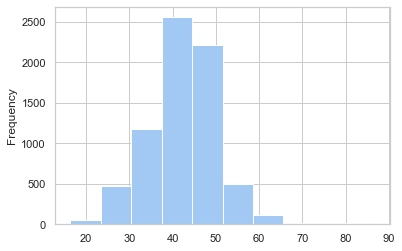

In [335]:
df2['adjpoll_clinton'].plot(kind='hist')
plt.show()

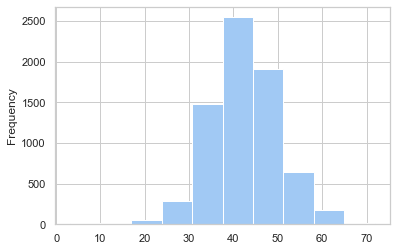

In [336]:
df2['adjpoll_trump'].plot(kind='hist')
plt.show()

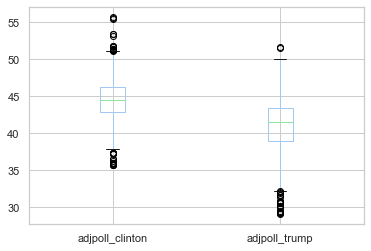

In [337]:
df_US.plot(kind='box')

### 7. Transforming Categorial Data -> Numerical ###

In [338]:
le1 = preprocessing.LabelEncoder()

le2 = preprocessing.LabelEncoder()


In [339]:
df2['state'] = le2.fit_transform(list(df2['state']))
df2['grade'] = le1.fit_transform(list(df2['grade']))

In [340]:
#df['winner'] = [1 if df['adjpoll_clinton'][i] > df['adjpoll_trump'][i] else 0 for i in range(len(df['adjpoll_clinton']))]
features = df2.columns

### 8. Splitting Dataset ###

Since dataset doesn't have label, splitting manually is best for this scenario

In [341]:
# Training Set
X_train = df2[features][:4992]

# Validation Set
X_valid = df2[features][4993:len(df2)]

# II. Isolation Forest #

Data is prepped and split and ready to be fit into Isolation Forest from sklearn

### 1. Fitting the Isolation Forest (IF) ###

In [342]:
from sklearn.ensemble import IsolationForest

In [343]:
clf = IsolationForest(n_estimators=100, max_samples='auto', behaviour ='new', contamination=0.1, random_state=42)
clf.fit(X_train)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

### 2.  Predicting the anomalies for both training set and validation set####

Both the training and validation datasets now have 2 other columns: 
  * Anomaly: prediction of the model: 1 for normal data point and -1 for possible outliers
  * Scores: anomaly scores calculated by the `decision function`

In [344]:
train_scores = clf.decision_function(X_train)
val_scores = clf.decision_function(X_valid)

X_valid['anomaly'] = clf.predict(X_valid)
X_valid['scores'] = val_scores

X_train['anomaly']=clf.predict(X_train)
X_train['scores']=train_scores


Getting the states label back: 

In [345]:
X_valid['state'] = list(le2.inverse_transform(X_valid['state']))


In [346]:
sum_correct = X_valid[X_valid['anomaly']==1].groupby('state').sum()
sum_incorrect = X_valid[X_valid['anomaly']==-1].groupby('state').sum()
sum_incorrect['anomaly'] = [i * -1 for i in sum_incorrect['anomaly']]

In [347]:
sum_incorrect.head(1)

,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
state,,,,,
Alabama,86,419.58461,840.66963,14,-0.721255


#### Since some states might not have any anomalies, finding these states is crucial in the overall model ####

Based on the results, 21 states were predicted to not have any anomalies in the validation dataset

In [348]:
res = []
for i in my_states:
    
    if i not in list(sum_incorrect.index):
        res.append(i)
res

['Florida',
 'Rhode Island',
 'Texas',
 'New Mexico',
 'Minnesota',
 'Oregon',
 'Ohio',
 'Pennsylvania',
 'Missouri',
 'Iowa',
 'Nevada',
 'North Carolina',
 'Louisiana',
 'Maine',
 'New Jersey',
 'Georgia',
 'Indiana',
 'Colorado',
 'Connecticut',
 'Michigan',
 'Kansas']

#### Now, adding the 0 values for anomaly and 1 for scores to show overall  `sum_incorrect` subset ####

The goal here is to see the total amount of anomalies in the validation dataset according to each states. Thus, values for `grade`, `adjpoll_clinton`, `adjpoll_trump` do not matter as the purpose is to demonstrate these on the US map. 

In [350]:
for i in res: 
    sum_incorrect.loc[i] = [0, 0, 0, 0, 1]
#index_to_add = pd.Index([i for i in res])
#sum_incorrect = sum_incorrect.append(index_to_add)

In [351]:
sum_incorrect.tail()

,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
state,,,,,
Indiana,0,0.0,0.0,0,1.0
Colorado,0,0.0,0.0,0,1.0
Connecticut,0,0.0,0.0,0,1.0
Michigan,0,0.0,0.0,0,1.0
Kansas,0,0.0,0.0,0,1.0


# III. Mapping data to US Map #

With the help from [this tutorial](https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f), amount of inliners - amount of normal data points in the validation dataset - can be mapped to the US map overall.

Shapefile is the original US map taken from [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

In [352]:
from pylab import *
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style= "whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

shp_path = "./cb_2018_us_state_5m/cb_2018_us_state_5m.shp"
sf = shp.Reader(shp_path)
len(sf.shapes())

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [353]:
df2 = read_shapefile(sf)
df2.head(56)


df2[df2.NAME=='New York'].index.get_values()[0]

18

In [354]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [355]:
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']
            colors = 'Purples'
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494'] 
            colors = 'YlGnBu'
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525'] 
            colors = 'Greys'
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:           
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']
            colors = 'YlOrBr'
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [356]:
def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        #i = i.upper()
        comuna_id.append(df[df.NAME == i].index.get_values()[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = x_lim, 
                                     y_lim = y_lim, 
                                     figsize = (15,9));

In [357]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (15,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
    
        for id in comuna:
            shape_ex = sf.shape(id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

### Getting correct_list and incorrect_list based on previous `sum_correct` and `sum_incorrect` DataFrames ###

In [358]:
correct_list = list(sum_correct['anomaly'])
incorrect_list = list(sum_incorrect['anomaly'])

When calling `plot_comunas_data()` fuction, the map will map our data from `correct_list` to the US map.

The darkest state represents the most amount of inliners, or least amount of outliers. In contrast, the lightest states represent the least amount of inliners, or most amount of outliers. 


1: 1 => 20 
2: 21 => 29 
3: 30 => 32 
4: 33 => 38 
5: 39 => 57 
6: 58 => 100 

   1   2   3   4   5   6


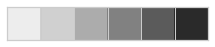

<Figure size 1080x648 with 0 Axes>

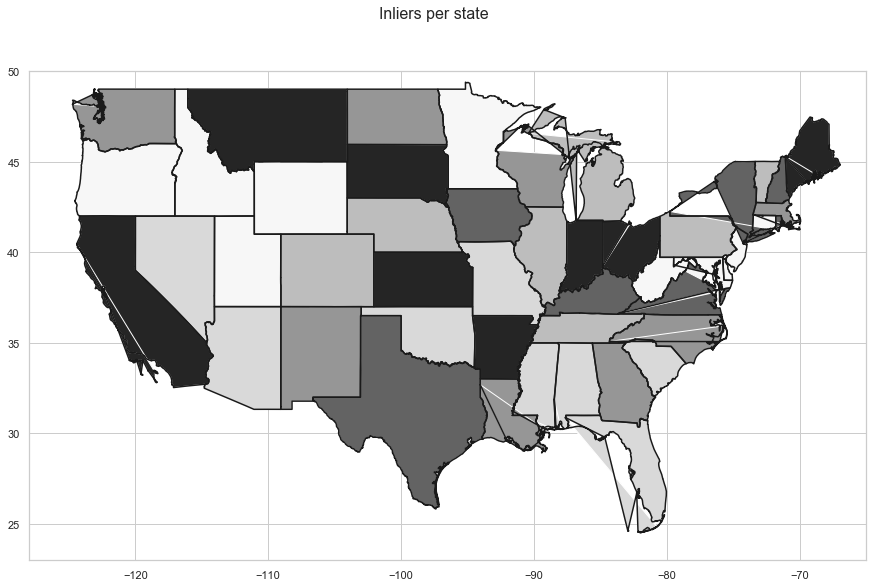

In [359]:
y_lim = (23, 50) # lat 
x_lim = (-128, -65) # long
my_states = list(set(X_valid['state']))
color_pallete = 3
plot_comunas_data(sf, "Inliers per state", my_states, correct_list, color_pallete, False)

However, when trying to map the results for `incorrect_list`, the function experiences some errors that require further analysis and coding to perfect. The code is still viewable through here: 

`color_pallete = 3
plot_comunas_data(sf, "Outliers per state", my_states, incorrect_list, color_pallete, False)`

# IV. Remarks #

Based on the map, the states with the most normal data points are: 
  * Florida
  * Maine
  * Michigan
  * Nevada
  * New Hampshire
  * North Carolina
  * Ohio
  * Pennsylvania
  * Virginia
  
To assess further, the amount of predicted inliners in the validation dataset can be viewed below:

In [360]:
sum_correct[sum_correct['anomaly'] >= 56]

,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
state,,,,,
Florida,440,4604.80256,4560.73961,101,8.447052
Maine,254,2708.26831,2339.31699,61,5.618447
Michigan,256,2661.53593,2417.20139,61,6.518783
Nevada,303,2782.88940,2815.11649,65,7.501152
New Hampshire,252,2929.18861,2565.07713,65,7.392964
North Carolina,357,3984.79104,4013.95297,90,9.664626
Ohio,307,3052.17790,3169.51567,72,7.559769
Pennsylvania,360,4212.33641,3905.97004,92,8.733580
Virginia,251,3085.74097,2629.77349,67,4.730624


### Percentage of anomalies in the validation dataset: ###

Based on the results below, there are 195 records predicted to be anomalies. That means, `195/2138*100` ~9.12% of anomalies in the validation dataset. 

In [361]:
X_valid[X_valid['anomaly']==-1]

,state,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
8263,Utah,8,26.32916,33.68345,-1,-0.031888
1404,Washington,10,47.85883,36.78597,-1,-0.016698
313,California,2,63.88869,26.51664,-1,-0.048090
7913,Utah,8,27.33101,32.55604,-1,-0.032707
708,Massachusetts,8,58.47790,29.41939,-1,-0.014138
...,...,...,...,...,...,...
8478,California,8,52.40491,31.85376,-1,-0.023673
4133,Maryland,5,56.52341,28.76217,-1,-0.007992
2018,Delaware,2,43.29377,23.70239,-1,-0.000999
7789,Kentucky,8,27.40880,60.63406,-1,-0.023143


In [362]:
X_valid.shape

(2138, 6)

### Percentage of anomalies in the training dataset: ###

Based on the results below, there are 500 records predicted to be anomalies. That means, `500 / 4992 * 100` ~ 10% of anomalies in the training dataset. 

In [363]:
X_train[X_train['anomaly']==-1]

,state,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
265,45,4,47.17089,21.701910,-1,-0.041541
1395,45,5,44.53185,29.110070,-1,-0.014168
7469,37,10,46.90264,33.676560,-1,-0.008191
606,4,0,51.10452,32.959240,-1,-0.012052
7190,0,3,25.37986,61.828900,-1,-0.064817
...,...,...,...,...,...,...
6266,48,5,23.69489,61.277220,-1,-0.074758
4338,45,8,51.22993,25.220440,-1,-0.050916
4401,17,8,29.51526,58.667880,-1,-0.000228
7675,8,8,85.33506,6.047079,-1,-0.174460


In [364]:
X_train

,state,grade,adjpoll_clinton,adjpoll_trump,anomaly,scores
265,45,4,47.17089,21.70191,-1,-0.041541
1774,37,3,54.30991,34.55259,1,0.075089
2614,49,2,36.95758,38.10036,1,0.034064
9603,9,3,39.78279,49.43355,1,0.117955
1395,45,5,44.53185,29.11007,-1,-0.014168
...,...,...,...,...,...,...
2171,29,2,42.57039,45.07587,1,0.142061
1175,20,3,54.02086,33.10349,1,0.093096
157,9,7,43.43343,48.44582,1,0.062204
1597,22,3,43.90165,36.86431,1,0.140302


### Evaluating Anomalies by Grade ###

Given 8 grades from mulitple pollsters in this dataset, it is necessary to see the anomalies in each based on the validation dataset

In [365]:
#Retrieving the grades 
X_valid['grade'] = list(le1.inverse_transform(X_valid['grade']))
grade_result = X_valid[X_valid['anomaly'] == -1].groupby('grade').sum()
grade_result['anomaly']

grade
A     -19
A+     -2
A-    -20
B     -40
B+     -4
B-     -3
C      -1
C+    -13
C-    -64
nan   -29
Name: anomaly, dtype: int64

We see that for grade `C-` pollsters has the most outliers, followed by grade `B`, then nan. Out of all the grades, grade `A+`, `B+`, `B-`, `C` have the least amount of anomalies, which could mean that these pollsters are more accurate and trustworthy 
